# Digit recogition model
dataset from: https://www.kaggle.com/datasets/bhavikjikadara/handwritten-digit-recognition/data

some code and ideas from this video:  https://www.youtube.com/watch?v=tHL5STNJKag 


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

class DigitsDataSetCSV(Dataset):
    def __init__(self, csv_file_path):
        # Load the CSV file into pandas DataFrame
        df = pd.read_csv(csv_file_path)

        # Features are normalized versions of the colour value
        # Targets are the number the images are supposed to represent
        self.features = df.iloc[:, 1:].to_numpy(dtype=np.float32) / 255
        self.targets = df.iloc[:, 0].to_numpy(dtype=np.float32)
        
        # Convert to PyTorch tensors

        self.features = torch.tensor(self.features)
        self.targets = self.targets.astype(int)

        # reshape tensors so timm model can use it.
        reshape_length = self.targets.size
       
        # reshape
        self.features = self.features.reshape([reshape_length, 1 ,28,28])
        new_features = torch.zeros([reshape_length, 3, 28,28])
        
        for i in range(len(self.features)):
            new_features[i] = torch.stack([self.features[i][0],self.features[i][0],self.features[i][0]])
        self.features = new_features
        
    def __len__(self):
        # Return the total number of rows in the dataset
        return len(self.targets)

    def __getitem__(self, idx):
        # Return one sample and its label at the given index
        return self.features[idx], self.targets[idx]

## Getting the data

### Testing if the processing worked

In [27]:
data_dir = './dataset/train/train.csv'
dataset = DigitsDataSetCSV(data_dir)

print(len(dataset))
image, label = dataset[1144]
print(len(dataset[1144]))
print('------')
print(image)
print('shape:')
print(image.shape)
print('label:')
print(label)
print(dataset.features.shape)

40000
2
------
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
shape:
torch.Size([3, 28, 28])
label:
9
torch.Size([40000, 3, 28, 28])


# Dataloader

In [28]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [29]:
for images, labels in dataloader:
    break

images.shape, labels.shape

(torch.Size([32, 3, 28, 28]), torch.Size([32]))

# Model

Credits to this video https://www.youtube.com/watch?v=tHL5STNJKag for the model code

In [30]:
class DigitClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(DigitClassifier, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280 # default of b0
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [31]:
# Create the model
model = DigitClassifier(10)
images.shape # shape should be 32 * 3 * 28 * 28

torch.Size([32, 3, 28, 28])

Example item

In [32]:
example_out = model(images)
print(example_out)
example_out.shape

tensor([[-5.2755e-01, -5.5717e-01, -7.1460e-01,  1.0636e-01,  1.2957e-01,
         -2.9055e-01,  2.2045e-01, -8.5017e-01,  1.9407e-02,  2.7663e-01],
        [ 1.0869e-01,  2.3991e-01, -3.9873e-01,  4.0919e-01,  3.8953e-01,
          2.7616e-01, -1.6532e-01,  9.2565e-02, -3.0679e-02, -1.0994e-01],
        [ 4.2053e-01, -1.7350e-01,  2.1590e-01,  6.9551e-06,  3.8632e-02,
          2.8776e-01,  5.1289e-01,  8.7864e-01,  2.6967e-01,  7.8051e-02],
        [-2.7142e-01, -3.7548e-02,  1.3735e-01,  3.5517e-01,  3.2106e-01,
         -6.2960e-01, -4.6935e-01,  1.5462e-01,  3.4177e-01, -2.5171e-01],
        [-2.5442e-01,  6.1203e-02, -1.5474e+00,  9.1206e-01, -1.0086e+00,
         -5.9077e-01, -2.2060e-01,  5.3243e-01, -1.1587e-01,  9.9036e-01],
        [-6.4585e-01, -8.0878e-01, -1.2986e-01, -1.2750e-01, -1.7747e-01,
         -4.4497e-01,  8.6362e-01, -7.4814e-02, -2.3520e-02,  7.7140e-01],
        [-1.4834e-01, -1.1451e-02, -1.5177e-01, -3.3083e-01, -3.2434e-01,
         -4.4635e-01,  2.8086e-0

torch.Size([32, 10])

In [33]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
print(criterion(example_out, labels))
print(example_out.shape, labels.shape)

tensor(2.3571, grad_fn=<NllLossBackward0>)
torch.Size([32, 10]) torch.Size([32])


Data files

In [43]:
train_folder = './dataset/train/train.csv'
valid_folder = './dataset/valid/valid.csv'
test_folder = './dataset/test/test.csv'

train_dataset = DigitsDataSetCSV(train_folder)
val_dataset = DigitsDataSetCSV(valid_folder)
test_dataset = DigitsDataSetCSV(test_folder)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Credits to this video https://www.youtube.com/watch?v=tHL5STNJKag for the training loop code.

In [44]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DigitClassifier(num_classes=10)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

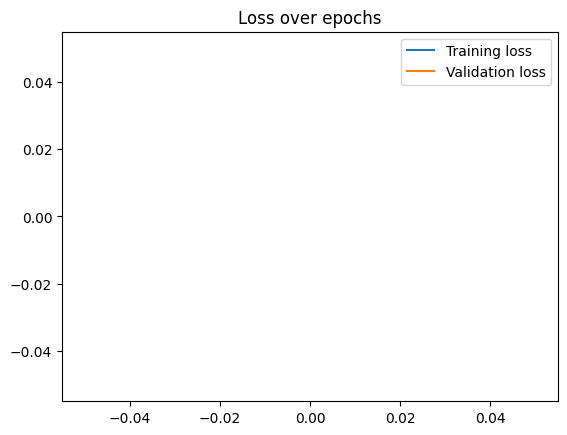

In [45]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()